### <strong>POPQUORN</strong>
<strong>Po</strong>tato-<strong>P</strong>rolific dataset for <strong>Qu</strong>estion-Answering, <strong>O</strong>ffensiveness, text <strong>R</strong>ewriting and politeness rating with demographic <strong>N</strong>uance

[Source](https://github.com/Jiaxin-Pei/potato-prolific-dataset)
___

Comprises <strong>four NLP tasks</strong>:
1. Offensiveness rating
2. Question Answering
3. Text rewriting / Style transfer
4. Politeness rating

### <strong>2.</strong> Question Answering (QA)

* Classified as "a [largely] objective task for span identification that is argued to test reading comprehension"
* Data is taken from [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) dataset
    * Also contains unanswerable questions
    * Each passage can contain multiple questions
* POPQUORN contains `695` questions with correct answers and `305` unanswerable questions
* Annotators were
    * drawn from US-population representative sample regarding sociodem. attributes (from [Prolific](https://www.prolific.com/))
    * given `10` passage and question pairs
    * asked to extract a text span as the answer to the question and to provide a difficulty rating (`1-5`)
    * asked to disclose sociodem. information
* Analysis and findings
    * Aggregated answers for each question by choosing the majority answer
    * Calculated token-level precision (`0.72`), recall (`0.79`) and F1 score (`0.75`) for every agg. answer
    * Manual examination of sample of size `50` showed
        * tendency to choose larger spans than necessary ($\uparrow$ recall, $\downarrow$ precision)
        * SQuAD's ground truths only being correct in `12` of the instances
    * Use of a mixed-effect model
        * Variables for gender, age, education and ethnicity as fixed effects
        * Instance as the random effect
    * Self-reported difficulty shows generally higher precision, higher F1 scores, and lower recall the higher the difficulty

    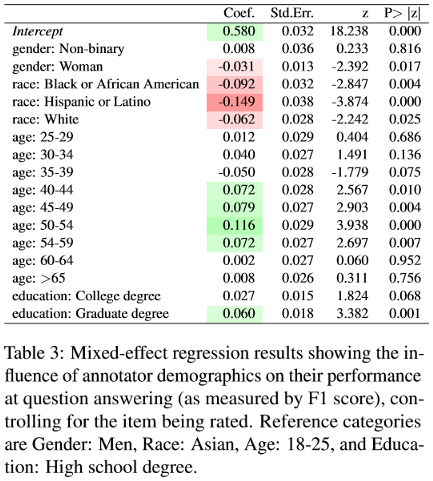

In [1]:
from IPython.display import display, HTML
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import krippendorff
import pandas as pd
import numpy as np
import copy
import json
import os

%matplotlib inline

In [2]:
path_to_dirs = '../../../data/Potato-Prolific-Dataset/dataset'
file_name = 'raw_data.csv'
sample_size=10

In [3]:
path_to_data = f'{path_to_dirs}/question_answering/{file_name}'

df = pd.read_csv(path_to_data)
df

,instance_id,user_id,text,question,groundtruth,answer,difficulty,gender,race,age,occupation,education
0,5727d8773acd2414000dedf4,NaN,Another who contributed significantly to the s...,"Albert Magnus was also known as ""Albert the wh...",Great,Great,1.0,Woman,White,18-24,Employed,College degree
1,5a14c4dca54d420018529339,NaN,"During the Cold War, the Asian power of Japan ...",What powers rebuilt their economies during 1949?,No answer,Japan and the European powers of the United Ki...,2.0,Woman,White,18-24,Employed,College degree
2,56d4f71e2ccc5a1400d833aa,NaN,"In October 2014, Beyoncé signed a deal to laun...",What type of clothing does the British partner...,activewear,No answer,1.0,Woman,White,18-24,Employed,College degree
3,5731c1cb0fdd8d15006c650f,NaN,Religious law centered on the ritualised syste...,What did participation in public religious rit...,commitment,a personal commitment to their community and i...,1.0,Woman,White,18-24,Employed,College degree
4,5a81fdc831013a001a335062,NaN,for any constant c. Matrix groups over these f...,The Galois group is adapted to the needs of wh...,No answer,algebraic geometry,1.0,Woman,White,18-24,Employed,College degree
...,...,...,...,...,...,...,...,...,...,...,...,...
4571,572821e5ff5b5019007d9dbf,NaN,"At present the A35 autoroute, which parallels ...",The traffic coming west of the city is from wh...,unité urbaine,No answer,5.0,Man,White,60-64,Self-employed,High school diploma or equivalent
4572,570e31310dc6ce1900204e62,NaN,From the Rigveda until the time of Pāṇini (fou...,How was Sanskrit viewed to be in relation to m...,conservative,No answer,5.0,Man,White,60-64,Self-employed,High school diploma or equivalent
4573,572962d53f37b31900478301,NaN,Sicily fell under the control of the Holy Roma...,What was Palermos population in 1330?,"51,000","By 1330, Palermo's population had declined to ...",1.0,Man,White,60-64,Self-employed,High school diploma or equivalent
4574,56bfed855a85de14001c7866,NaN,"In December, Beyoncé along with a variety of o...",What was the focus of the Gucci Chime for Chan...,spread female empowerment,"Gucci ""Chime for Change"" campaign that aims to...",1.0,Man,White,60-64,Self-employed,High school diploma or equivalent


### 2.1 General stats

In [4]:
meta_cols = list(df.columns[df.columns.get_loc('gender'):])
df_users = df[meta_cols].drop_duplicates()

In [5]:
# Number of instances, number of annotators

num_inst = df['instance_id'].nunique()
num_annotr = 459 # value taken from the paper, as user_ids are not given here
annotn_options = sorted(df['difficulty'].unique())

print(f"Number of instances: {num_inst}")
print(f"Number of annotators: {num_annotr} (paper)")
print(f"Annotation options: {annotn_options}")

Number of instances: 1000
Number of annotators: 459 (paper)
Annotation options: [1.0, 2.0, 3.0, 4.0, 5.0]


In [6]:
# Number of annotations per instance

num_annotn_per_inst = df.groupby('instance_id').size()
print(f"Number of annotations per instance:\n{num_annotn_per_inst.mean():.2f} MEAN, {num_annotn_per_inst.std():.2f} STD")
print(f"Fewest annotations: {num_annotn_per_inst.min()}")
print(f"Most annotations: {num_annotn_per_inst.max()}")

Number of annotations per instance:
4.58 MEAN, 0.61 STD
Fewest annotations: 2
Most annotations: 5


In [7]:
# Instance text lengths

inst_texts = df['text'].unique()
inst_text_lengths_char = [len(text) for text in inst_texts]
inst_text_lengths = [len(text.split()) for text in inst_texts]

print(f"Instance text lengths (chars):\n{np.mean(inst_text_lengths_char):.2f} MEAN, {np.std(inst_text_lengths_char):.2f} STD")
print(f"Instance text lengths (words):\n{np.mean(inst_text_lengths):.2f} MEAN, {np.std(inst_text_lengths):.2f} STD")

Instance text lengths (chars):
864.15 MEAN, 304.05 STD
Instance text lengths (words):
134.73 MEAN, 49.31 STD


In [8]:
# Instance question lengths

inst_questions = df['question'].unique()
inst_question_lengths_char = [len(q) for q in inst_questions]
inst_question_lengths = [len(q.split()) for q in inst_questions]

print(f"Instance question lengths (chars):\n{np.mean(inst_question_lengths_char):.2f} MEAN, {np.std(inst_question_lengths_char):.2f} STD")
print(f"Instance question lengths (words):\n{np.mean(inst_question_lengths):.2f} MEAN, {np.std(inst_question_lengths):.2f} STD")

Instance question lengths (chars):
58.41 MEAN, 20.30 STD
Instance question lengths (words):
9.92 MEAN, 3.45 STD


In [9]:
# Instance answer lengths

inst_answers = df['answer'].unique()
inst_answers = np.delete(inst_answers, np.where(inst_answers == 'No answer'))
inst_answer_lengths_char = [len(q) for q in inst_answers]
inst_answer_lengths = [len(q.split()) for q in inst_answers]

num_no_answer = df['answer'].value_counts()['No answer']

print(f"Instance answer lengths (chars):\n{np.mean(inst_answer_lengths_char):.2f} MEAN, {np.std(inst_answer_lengths_char):.2f} STD")
print(f"Instance answer lengths (words):\n{np.mean(inst_answer_lengths):.2f} MEAN, {np.std(inst_answer_lengths):.2f} STD")
print(f"Instances where no answer is given (\'No answer\'):\n{num_no_answer}")

Instance answer lengths (chars):
60.55 MEAN, 72.67 STD
Instance answer lengths (words):
9.57 MEAN, 11.50 STD
Instances where no answer is given ('No answer'):
1064


In [10]:
# NaN entries

num_nan = df.isna().sum().sum()
num_nan_except_user_ids = df.drop(columns=['user_id']).isna().sum().sum()
print(f"Number of NaN entries: {num_nan}")
print(f"Number of NaN entries besides user IDs: {num_nan_except_user_ids}")

Number of NaN entries: 4576
Number of NaN entries besides user IDs: 0


### 2.2 Sociodemographic information

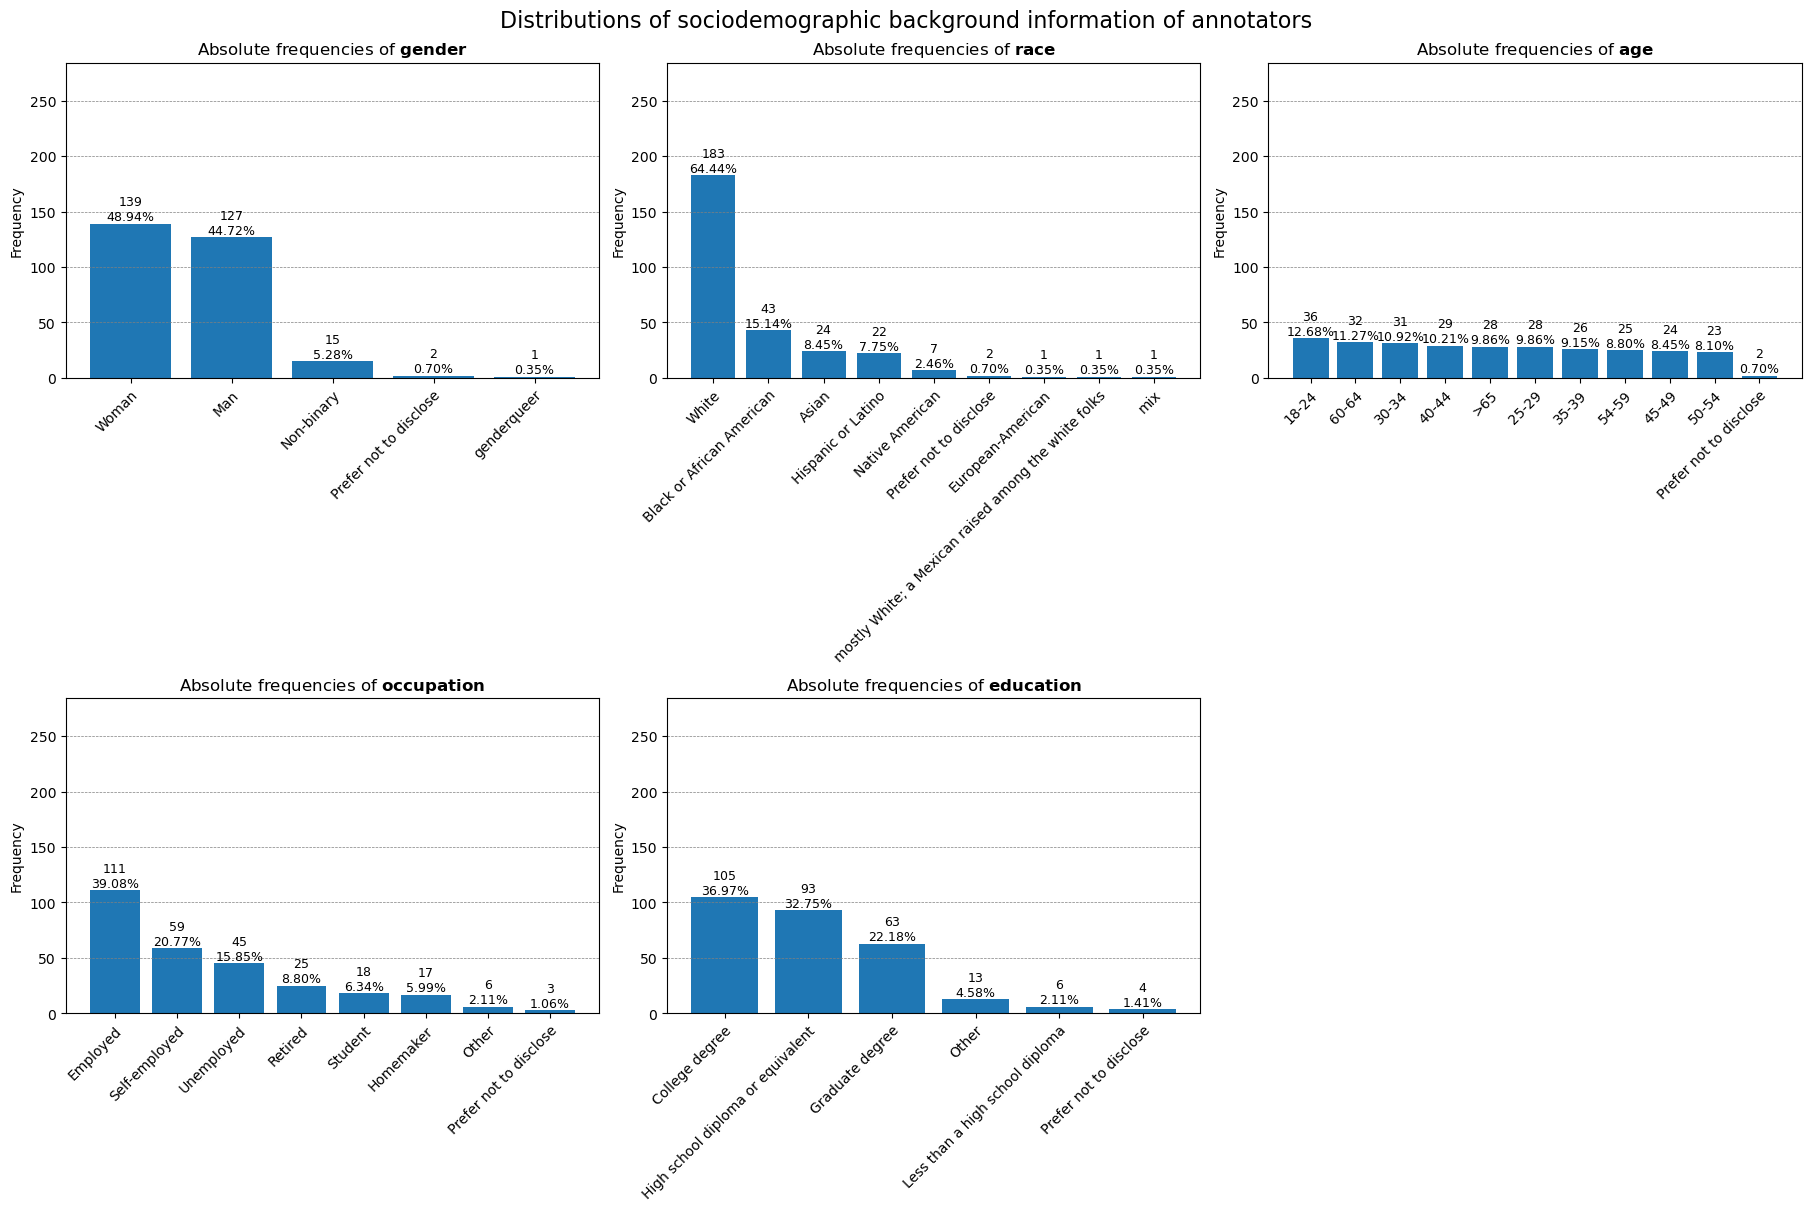

In [11]:
# track the frequencies of each sociodemographic attribute's values
meta_dict = {attr: None for attr in df_users.columns}

fig, axes = plt.subplots(2, 3, figsize=(18,12), constrained_layout=True)
fig.suptitle("Distributions of sociodemographic background information of annotators", fontsize=16)
axes = axes.flatten()
axes[5].axis('off')

l = df_users.columns.get_loc('gender')
for i, column in enumerate(df_users.columns[l:]):
    
    abs_freqs = df_users[column].value_counts()
    rel_freqs = df_users[column].value_counts(normalize=True)
  
    bars = axes[i].bar(abs_freqs.index, abs_freqs.values)
    axes[i].set_title(rf"Absolute frequencies of $\bf{{{column}}}$")
    axes[i].set_ylabel("Frequency")
    axes[i].set_ylim(0, len(df_users))
    
    meta_dict[column] = dict(map(lambda i,j : (i,j) , rel_freqs.index, rel_freqs.values))
    
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_rotation_mode('anchor')

    # label the bars with the absolute and relative frequency values
    for bar, abs_freq, rel_freq in zip(bars, abs_freqs, rel_freqs):
        # save the frequencies for later
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{abs_freq}\n{rel_freq*100:.2f}%',
            ha='center',
            va='bottom',
            fontsize=9)    
    
    # add horizontal lines
    for y in axes[i].get_yticks():
        axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
        
plt.show()

### 2.3 Annotations, Disagreement

### 2.3.1 Example annotation distributions

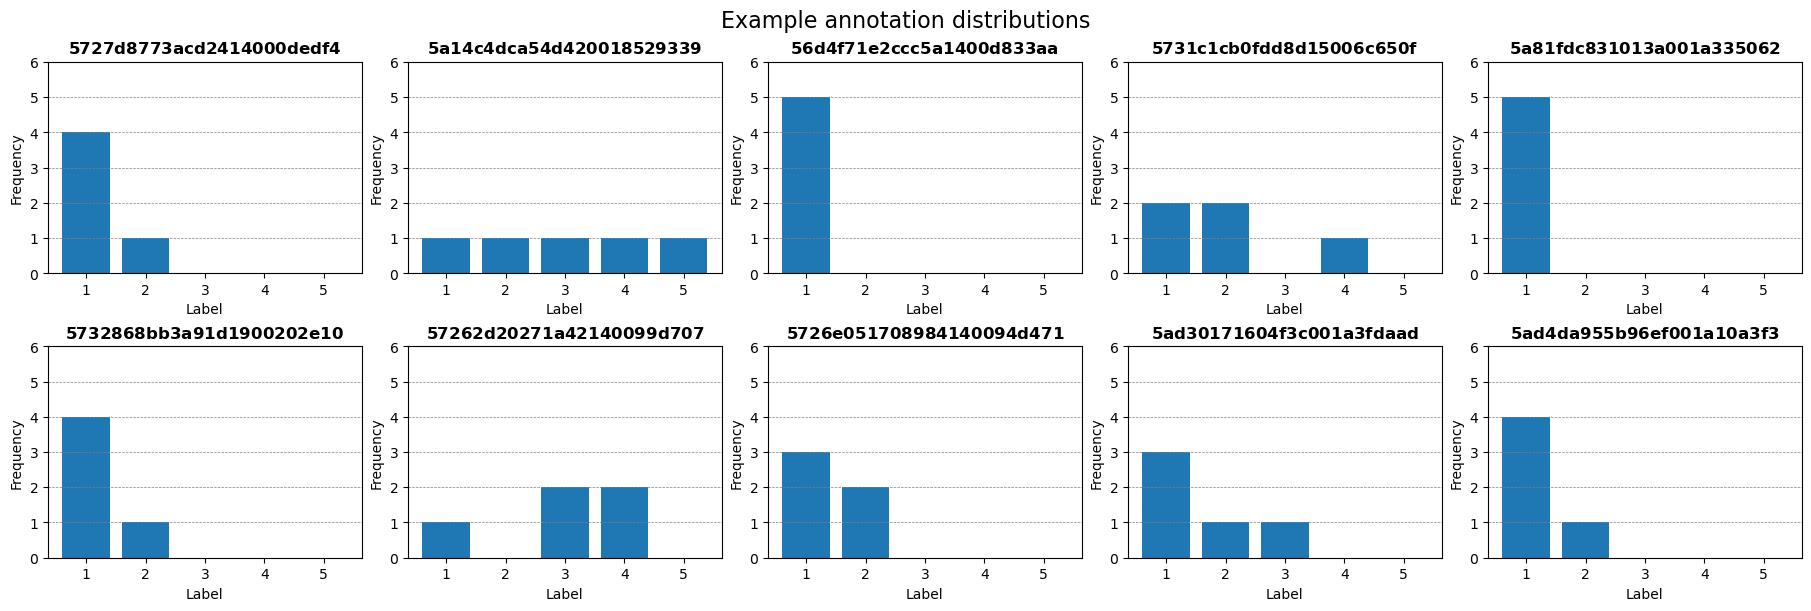

In [12]:
# Some example annotation distributions

df_qa = df.groupby('instance_id')['difficulty'].apply(list).reset_index()

def aggregate_annotations(annotn):
    annotn_dict = dict.fromkeys(annotn_options, 0)
    for a in annotn:
        annotn_dict[a] += 1 
    return annotn_dict

def plot(ids, title):
    nrows = 2 if len(ids) > 5 else 1
    fig, axes = plt.subplots(nrows, 5, figsize=(18,3*nrows), constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i, id in enumerate(ids):
        diff = df_qa.loc[df_qa['instance_id'] == id, 'difficulty'].iloc[0]
        annotn_dict = aggregate_annotations(diff)

        bars = axes[i].bar(annotn_dict.keys(), annotn_dict.values())
        axes[i].set_title(rf"$\bf{{{id}}}$")
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel("Frequency")
        axes[i].set_ylim(0, num_annotn_per_inst.max()+1)

        # add horizontal lines
        for y in axes[i].get_yticks():
            axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
    
    upper = int(sample_size/2) if nrows == 1 else sample_size
    for j in range(len(ids), upper):
        axes[j].axis('off')
    
    plt.show()
    
plot(df['instance_id'].iloc[:10], "Example annotation distributions")

### 2.3.2 Perfect agreement

In [13]:
# Perfect agreement

perfect_agreement = df_qa[df_qa['difficulty'].apply(lambda x: len(set(x)) == 1.0)]
perfect_agreement_besides_1 = perfect_agreement['difficulty'].apply(lambda x: any(item != 1.0 for item in x))

print(f"Number of instances with perfect agreement: {len(perfect_agreement)}")
print(f"Number of instances with perfect agreement besides label 1.0: {len(perfect_agreement[perfect_agreement_besides_1])}")
print(f"Number of instances with disagreement: {num_inst - len(perfect_agreement)}")

Number of instances with perfect agreement: 146
Number of instances with perfect agreement besides label 1.0: 4
Number of instances with disagreement: 854


### 2.3.3 Disagreement

[**Gini Index**](https://www.javatpoint.com/gini-index-in-machine-learning)

The Gini Index is a proportion of impurity or inequality in statistical and monetary settings. In machine learning, it is utilized as an impurity measure in decision tree algorithms for classification tasks. The higher, the more impure.

$$Gini = 1-\sum_{i=1}^n(p_i)^2$$


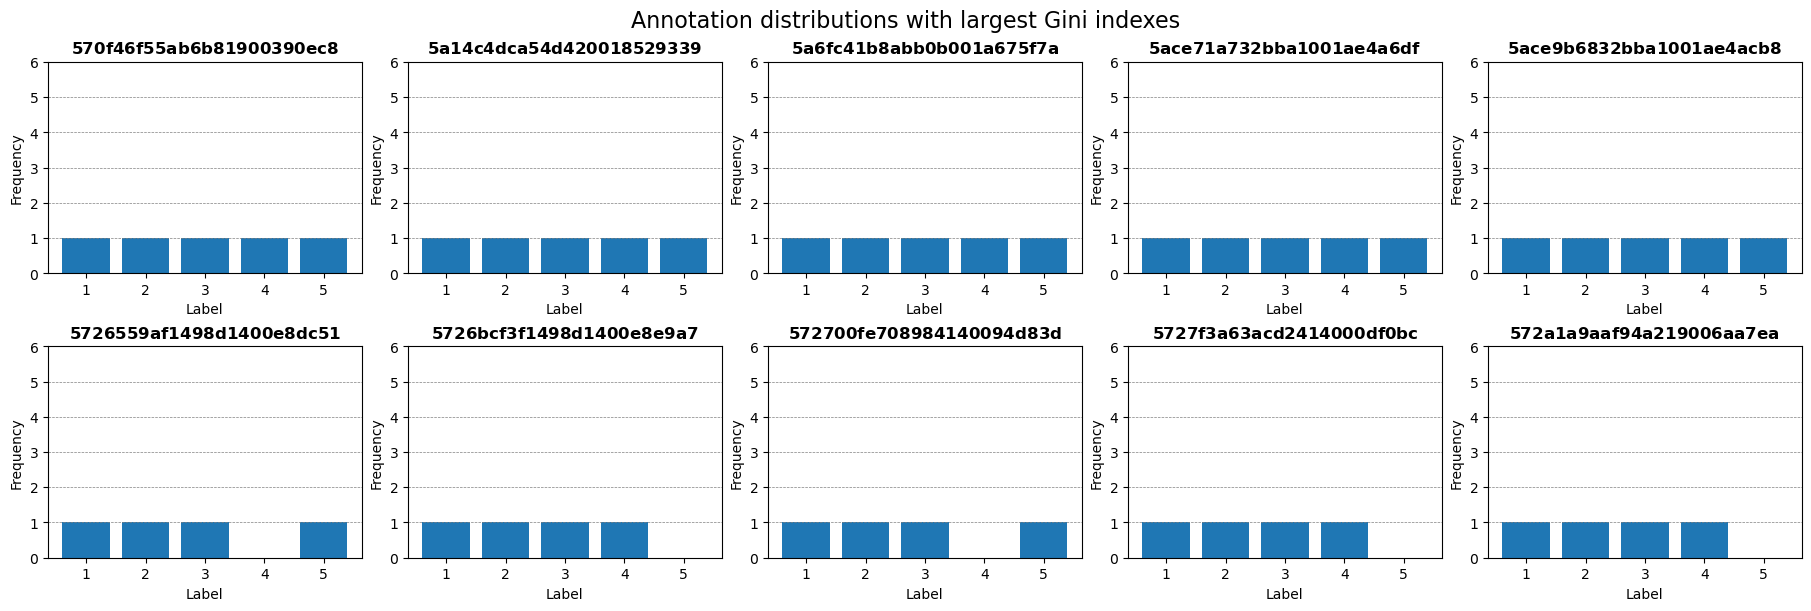

In [14]:
def calc_gini_index(annotn):
    sum_ = 0
    unique_vals = list(set(annotn))
    for val in unique_vals:
        sum_ += (annotn.count(val)/len(annotn))**2
    return round(1 - sum_, 3)

df_qa['gini_index'] = df_qa['difficulty'].apply(calc_gini_index)
df_qa = df_qa.sort_values(by=['gini_index'], ascending=False, kind='stable')

plot(df_qa['instance_id'][:sample_size], "Annotation distributions with largest Gini indexes")

[**Krippendorff's $\alpha$**](https://github.com/pln-fing-udelar/fast-krippendorff/)

In [15]:
df_qa['value_counts'] = [
    [inst.count(i) for i in annotn_options] for inst in df_qa['difficulty']
]

value_counts = np.array(df_qa['value_counts'].to_list())
print("Krippendorff's alpha:", krippendorff.alpha(value_counts=value_counts, level_of_measurement='ordinal'))

Krippendorff's alpha: 0.2314872470495798


[**Divergence**](https://aclanthology.org/2024.nlperspectives-1.7/)

Given a set of annotations for a given data instance $\{a_1, a_2, ..., a_N\}$,

the agreement $g_i$ for annotator $i \in [1,N]$ and the divergence $d$ are computed as follows ($g$ assumed to be an average in computing $d$):
$$g_i = \frac{1}{N}\sum_{i\neq j}a_i == a_j, \;\;\; \{g_1, g_2, ..., g_N\} =: g$$
$$d = 1-\frac{g}{max(g)} \in [0,1]$$

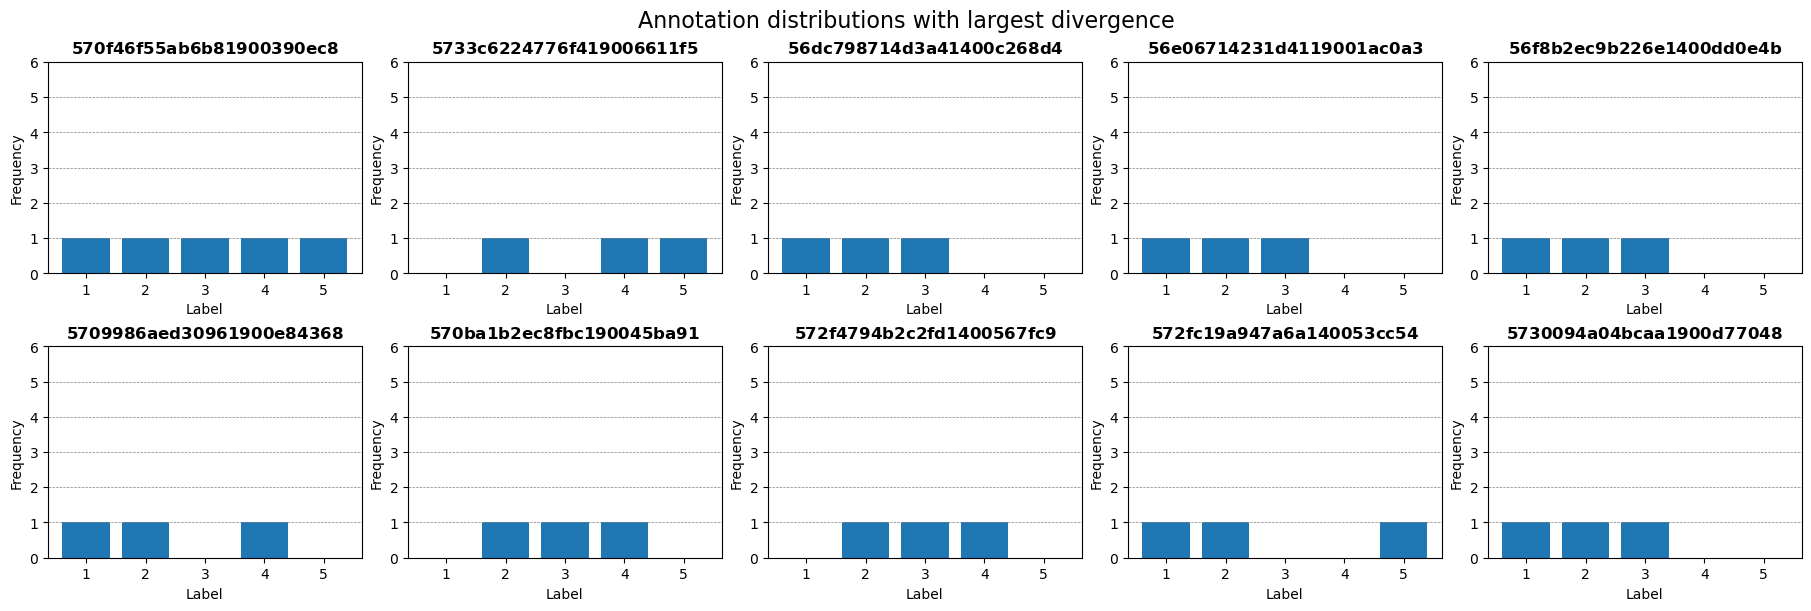

In [18]:
def calc_divergence(x):
    g = [x.count(i)-1 for i in x]
    # handle division by zero (complete disagreement, i.e. no repeat values -> g is all zeros)
    return 1 if max(g) == 0 else 1 - (sum(g)/len(g))/max(g)

df_qa['divergence'] = df_qa['difficulty'].apply(calc_divergence)
df_qa = df_qa.sort_values(by=['divergence'], ascending=False, kind='stable')
plot(df_qa['instance_id'][:sample_size], "Annotation distributions with largest divergence")

**Inspect instances**

In [21]:
# Using the Gini index
degree = 'moderate'
ids = df_qa.sort_values(by=['gini_index'], ascending=False, kind='stable')['instance_id'][len(df_qa)//2:len(df_qa)//2+sample_size]
texts = df[df['instance_id'].isin(ids)][['instance_id', 'text']].drop_duplicates()
texts_dict = dict(zip(texts.instance_id, texts.text))

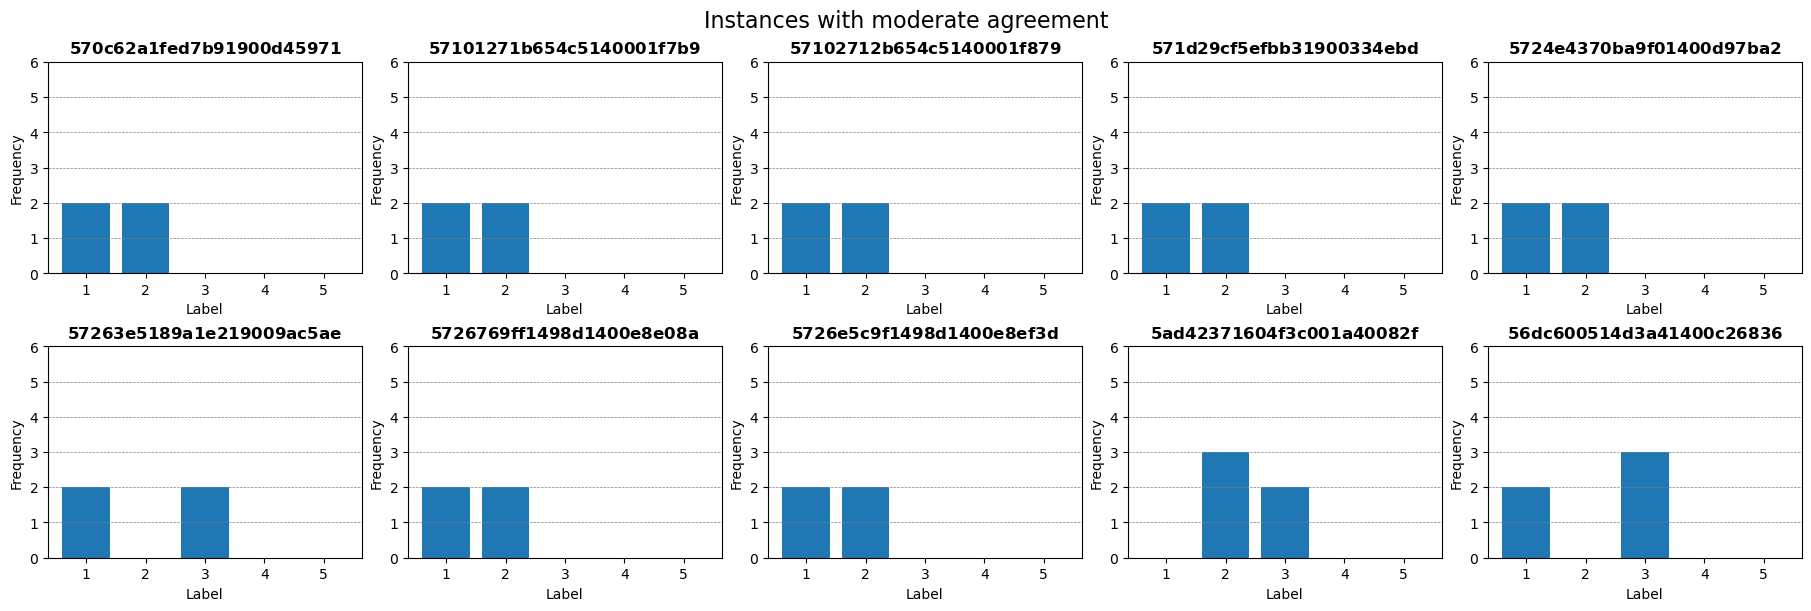

In [23]:
plot(ids, f"Instances with {degree} agreement")

In [ ]:
dir_name = 'extracted_texts'
file_name = f'texts_{degree}_agreement.json'
path_to_file = f'{dir_name}/{file_name}'
update = True # whether or not to update the file

if update:
    if os.path.exists(path_to_file) and os.path.getsize(path_to_file) > 0:
        with open(path_to_file) as f:
            texts_dict_ = json.load(f)
        texts_dict_['qa'] = texts_dict
    else: 
        texts_dict_ = dict()
        texts_dict_['qa'] = texts_dict

    with open(path_to_file, "w+") as f:
        json.dump(texts_dict_, f, indent=4)

### 2.3.4 Single majority label

Number of instances with a single majority for...
thresh = 1.0: 807
thresh = 2.0: 497
thresh = 3.0: 272
thresh = 4.0: 132


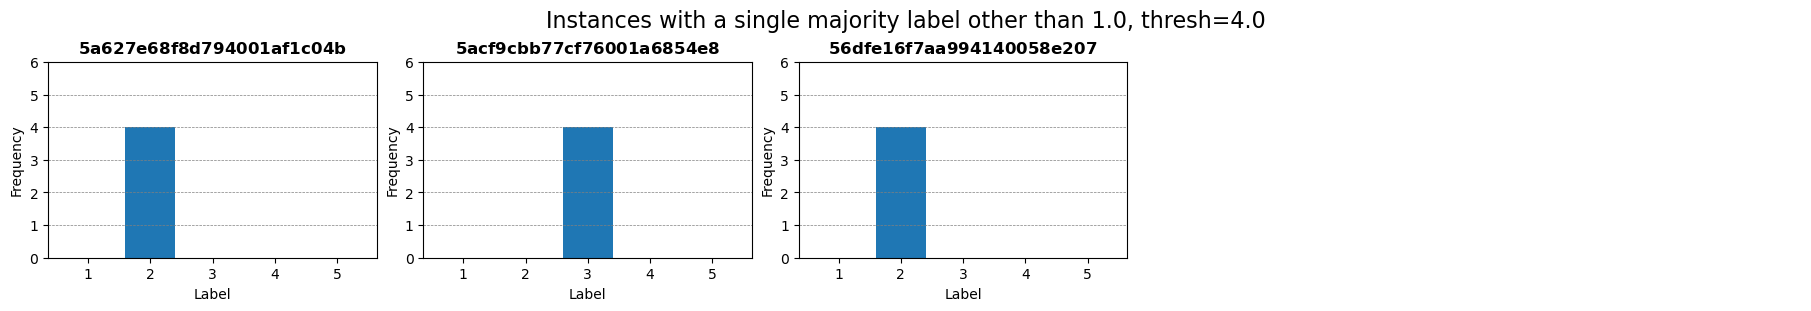

thresh = 5.0: 74


In [ ]:
# Instances with a single majority

def get_majority_labels(d):
    max_value = max(d.values())
    # if there are multiple labels with the same highest count, return them all, though the single majority condition is not fulfilled
    maj_labels = [key for key, value in d.items() if value == max_value]
    return maj_labels[0] if len(maj_labels) == 1 else maj_labels

def has_single_majority(annotn, thresh):
    annotn_dict = dict.fromkeys(annotn_options, 0)
    for a in annotn:
        annotn_dict[a] += 1
    annotn_dict_sorted = dict(sorted(annotn_dict.items(), key=lambda x: x[1], reverse=True))
    counts = list(annotn_dict_sorted.values())
    majority_labels = get_majority_labels(annotn_dict_sorted)
    cond = counts[0] >= counts[1] + thresh
    return majority_labels, cond


verbose = False
print(f"Number of instances with a single majority for...")
for thresh in annotn_options:
    df_qa['tmp'] = df_qa['difficulty'].apply(has_single_majority, thresh=thresh)
    df_qa[['majority_labels', 'has_single_majority']] = df_qa['tmp'].apply(pd.Series)
    df_qa.drop(columns=['tmp'], inplace=True)

    df_qa_maj = df_qa[df_qa.has_single_majority]
    print(f"thresh = {thresh}: {len(df_qa_maj)}")
    
    distr = df_qa_maj['majority_labels'].value_counts().reset_index()
    if verbose: display(distr)
    
    if thresh == 4:
        ids = df_qa_maj.loc[df_qa_maj['majority_labels'] != 1.0, 'instance_id'][:10]
        plot(ids, f"Instances with a single majority label other than 1.0, thresh={thresh}")
        if verbose: 
            with pd.option_context('display.max_colwidth', None):
                for id_ in ids:
                    display(df.loc[df['instance_id'] == id_][['text', 'difficulty']].reset_index())

### 2.3.5 Annotation variety

In [36]:
# Annotation variety

# Aggregate the sociodem. meta information for each instance's annotators (for 1.3.6)
df_meta = df.groupby('instance_id').agg({
    'difficulty': list,
    'gender': list,
    'race': list,
    'age': list,
    'occupation': list,
    'education': list
}).reset_index()

In [37]:
df_meta['num_different_labels'] = df_meta['difficulty'].apply(lambda x: len(set(x)))
df_labels = df_meta['num_different_labels'].value_counts().reindex([1,2,3,4,5]).reset_index()
df_labels

,num_different_labels,count
0,1,146
1,2,380
2,3,367
3,4,102
4,5,5


### 2.3.6 Links to sociodemographic background information

In [38]:
# for each of the five different numbers of different labels instances can have,
# go over all instances that apply and, for each value of each sociodemographic attribute, 
# sum up the frequencies in which they occur across those instances, overage them and compare it with the 
# true frequency in meta_dict.
def count_freqs(list_, attr, dict_):
    for val in dict_[attr].keys():
        dict_[attr][val] += list_.count(val) / len(list_)
    return dict_

meta_dict_full = dict()

for _, row in df_labels.iterrows():
    meta_dict_ = {attr: {val: 0 for val in meta_dict[attr].keys()} for attr in meta_dict.keys()}
    df_ = df_meta[df_meta['num_different_labels'] == row.iloc[0]]

    l = df_.columns.get_loc('gender')
    r = df_.columns.get_loc('education')
    for attr in df_.columns[l:r+1]:
        meta_dict_sums = df_[attr].apply(count_freqs, attr=attr, dict_=meta_dict_)
    
    meta_dict_sums = meta_dict_sums.iloc[0]
    for attr, val_dict in meta_dict_sums.items():
        meta_dict_sums[attr] = {k: v / row.iloc[1] for k, v in val_dict.items()}

    meta_dict_full[int(row.iloc[0])] = meta_dict_sums

In [ ]:
for i in meta_dict_full.keys():
    print(f"================= {i} different label(s) =================")
    print(json.dumps({
    outer_key: {key: meta_dict[outer_key][key] - meta_dict_full[i][outer_key][key] 
                for key in meta_dict[outer_key]} 
    for outer_key in meta_dict
    }, sort_keys=True, indent=4))

# value above 0 -> that attribute value has appeared less frequently than the average
# value below 0 -> that attribute value has appeared more frequently than the average